In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import LogNorm, PowerNorm
import mpl_scatter_density

In [2]:
from datetime import datetime

In [3]:
from scipy.spatial.ckdtree import cKDTree

In [4]:
from astropy import units as u
from astropy.utils.console import ProgressBar

In [5]:
from rockstar.models import RockstarHalo, RockstarCatalogue

In [6]:
catalogues = RockstarCatalogue.objects.all()
cat = catalogues[0]
cat_umass = cat.unit_mass
cat_ulength = cat.unit_length
cat_rlength = u.def_unit('kpc/h', cat.unit_length/1000)

boxlength = cat.snapshot.simulation.get_box_length().to(cat_ulength)

print(boxlength)

50.00000678186229 Mpc/h


In [7]:
old_halos = [
    233107,
    172676,
    158699,
    60717,
    228540,
    184999,
    70678,
    136214,
    171766,
    157661,
    117322,
    32978,
    1227,
    171739,
    50660,
    2848,
    182073,
    172029,
    158145,
    228338,]

In [8]:
def Dnf(hid, f=1, k=1):
    """
    Compute a halo mass independent environmental paramenter as defined by
    Haas, Schaye and Jeeson-Daniel (2011)
    
    Dnf is the distance to the k-nearest halo with Mvir_n at least f*Mvir_c scaled by
    the neighbour virial radius Rvir_n
    
    i.e.
    
    D(k,f) = r_n(Mvir_n > f * Mvir_c) / Rvir_n
    
    Default values are f=1, k=1
    
    """
    h0 = halos.loc[hid]
    mvir = h0.mvir
    pos = h0[['x', 'y', 'z']].values
    
    others = halos[halos.mvir > f*mvir]
    # remove hid from others
    others = others[others.hid != hid]
    tree = cKDTree(others[['x', 'y', 'z']].values, boxsize=boxlength)
    
    dd, ii = tree.query(pos, k=k)
    
    hother = others.iloc[ii]
    rvir_other = hother.rvir * cat_rlength.to(cat_ulength)
    
    return dd/rvir_other

Dnf = np.vectorize(Dnf)

# Load catalogue

In [9]:
Mmin = 1e9

# select halos min Mvir >= Mmin
halos = RockstarHalo.objects.filter(catalogue=cat, )
halos = halos.filter(mvir__gte=Mmin)

# store them into df
columns = ['hid', 'x', 'y', 'z', 'rvir', 'mvir', 'np']
halos = pd.DataFrame(list(halos.values(*columns)))
halos = halos.set_index(halos.hid)

# create tree
halos_tree = cKDTree(halos[['x', 'y', 'z']], boxsize=boxlength)

In [10]:
Mmin = 5e9
Mmax = 1e13

# select halos with min Mvir >= mmin AND Mvir <= Mmax

halos_sel = RockstarHalo.objects.filter(catalogue=cat, )
halos_sel = halos_sel.filter(mvir__gte=Mmin)
halos_sel = halos_sel.filter(mvir__lte=Mmax)

# store them into df
df_sel = pd.DataFrame(list(halos_sel.values(*columns)))
df_sel = df_sel.set_index(df_sel.hid)

# Find neighbours inside Rvir

In [11]:
# get the rvirs and convert them to the same units as positions
rvir = df_sel.rvir * cat_rlength.to(cat_ulength)

In [10]:
# For each selected halo find neighbours inside the halo virial radius

neighbours = []
with ProgressBar(len(rvir), ipython_widget=True) as pbar:
    i = 0
    for pos, r in zip(df_sel[['x', 'y', 'z']].values, rvir):
        nei = halos_tree.query_ball_point(pos, r)
        
        # remove the central halo from the neighbours list
        # and store the hids of neighbours
        hid_sel = df_sel.iloc[i].hid
        
        out = []
        for j in nei:
            hid_full = halos.iloc[j].hid
            if hid_full != hid_sel:
                out.append(hid_full)
        
        neighbours.append(out)
        i += 1
        pbar.update()

In [11]:
# find halos for which their Mvir is more than 4 times the Mvir of other halos inside rvir

mask = []
with ProgressBar(len(neighbours), ipython_widget=True) as pbar:
    for i, nei in enumerate(neighbours):
        Mvir = df_sel.iloc[i].mvir

        out = True
        for hid in nei:
            Mvir_other = halos.loc[hid].mvir
            if Mvir < 4 * Mvir_other:
                out = False

        mask.append(out)
        pbar.update()       
        
df2 = df_sel[mask]

In [12]:
# For each selected halo find neighbours inside 1 h-1 Mpc

R = 1 # h-1 Mpc

tree2 = cKDTree(df2[['x', 'y', 'z']].values, boxsize=boxlength)
out_neighbours_i = tree2.query_ball_tree(halos_tree, R)

In [15]:
# get out_neighbours hids and remove central halo from list

out_neighbours = []

with ProgressBar(len(out_neighbours_i), ipython_widget=True) as pbar:
    for i, nei in enumerate(out_neighbours_i):
        hid_sel = df2.iloc[i].hid

        out = list(halos.iloc[nei].hid)
        out.remove(hid_sel)
        
        out_neighbours.append(out)
        pbar.update()

In [16]:
# find halos with no galaxy larger than 1e13 h-1 inside a 1 h-1 Mpc radius

out_Mmax = 1e13 # h-1 Msun

mask = []
with ProgressBar(len(out_neighbours), ipython_widget=True) as pbar:
    for i, nei in enumerate(out_neighbours):
        Mvir = df_sel.iloc[i].mvir
        
        Mvir_other = halos.loc[nei].mvir.max()

        out = True
        if Mvir_other > out_Mmax:
            out = False

        mask.append(out)
        pbar.update()       
        
df3 = df2[mask]

In [17]:
# filter selected halos to final mass range

minMass = 5e9
maxMass = 1e13
df_filter = df3[np.logical_and(df3.mvir>minMass, df3.mvir<maxMass)]

filter_tree = cKDTree(df_filter[['x', 'y', 'z']], boxsize=boxlength)

In [18]:
# find neighbours inside 1 h-1 Mpc sphere
R = 1 # h-1 Mpc

filter_neighbours_i = filter_tree.query_ball_tree(halos_tree, R)

In [19]:
# get filter_neighbours hids and remove central halo from list

filter_neighbours = []

with ProgressBar(len(filter_neighbours_i), ipython_widget=True) as pbar:
    for i, nei in enumerate(filter_neighbours_i):
        hid_sel = df_filter.iloc[i].hid

        out = list(halos.iloc[nei].hid)
        out.remove(hid_sel)
        
        filter_neighbours.append(out)
        pbar.update()

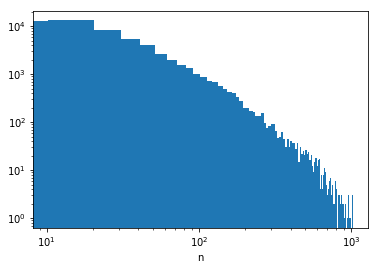

In [30]:
# get number of neighbours
count_n = [len(j) for j in filter_neighbours]
plt.hist(count_n, bins=100)
plt.xlabel("n")

plt.xscale('log')
plt.yscale('log')


# store in df_filter

df_filter['count_n'] = count_n

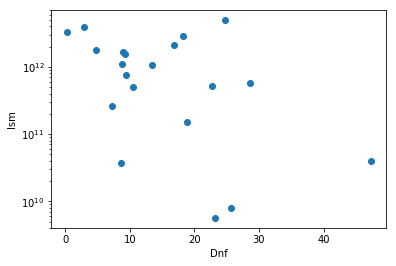

In [33]:
# check Dnf of old_halos

dnf = []
for hid in old_halos:
    dnf.append(Dnf(hid))
    
    
plt.scatter(dnf, halos.loc[old_halos].mvir)
plt.yscale('log')

plt.xlabel('Dnf')
plt.ylabel('lsm')

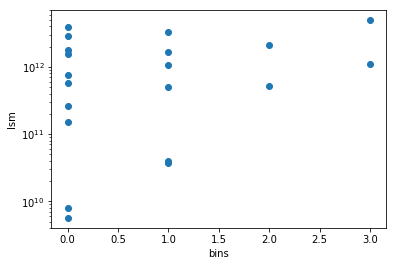

In [34]:
# check bins for old halos

old_n_bins = [0,
0,
0,
0,
0,
0,
0,
0,
1,
1,
1,
1,
1,
0,
0,
1,
2,
3,
2,
3,]

plt.scatter(old_n_bins, halos.loc[old_halos].mvir)
plt.yscale('log')

plt.xlabel('bins')
plt.ylabel('lsm')

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


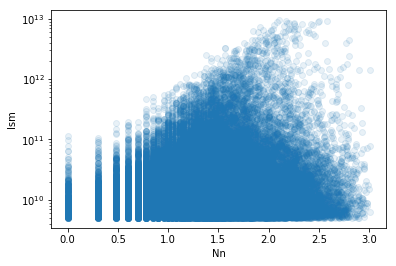

In [35]:
plt.scatter(np.log10(count_n), df_filter.mvir, alpha=.1)
plt.yscale('log')
# plt.xscale('log')

#plt.hist2d(np.log10(dnf), np.log10(df_filter.mvir), bins=20)
#plt.colorbar(label='N')

plt.xlabel('Nn')
plt.ylabel('lsm')

In [36]:
hids = df_filter.hid
dnf = []

with ProgressBar(len(hids), ipython_widget=True) as pbar:
    for hid in hids:
        dnf.append(Dnf(hid))
        pbar.update()
        
dnf = np.array(dnf).flatten()

In [37]:
# store dnf
df_filter['dnf'] = dnf

In [38]:
# save to disk
df_filter.to_csv("halos_classified.csv", index=False)

## Continue from storage

In [12]:
# load from disk
df_filter = pd.read_csv('halos_classified.csv')
df_filter = df_filter.set_index(df_filter.hid)

df_filter

hid          mvir     rvir         x         y         z  count_n  \
hid                                                                            
4898      4898  7.221000e+09   39.150   2.57446   1.85562   0.06989        1   
3314      3314  2.445000e+10   58.791   1.04897   3.11749   0.93578       13   
4455      4455  8.206000e+09   40.855   1.49427   3.14610   0.91008       13   
5677      5677  5.252000e+09   35.207   1.45052   2.43811   1.31365       11   
4236      4236  8.863000e+09   41.916   1.49207   3.13004   0.72970       13   
7684      7684  1.329000e+10   47.982   1.42623   3.20164   0.00002       16   
3095      3095  3.471000e+10   66.073   2.12547   2.33555   1.06137        9   
4652      4652  5.990000e+09   36.786   2.26220   2.19966   2.06242       19   
2788      2788  4.374000e+10   71.365   2.18379   1.85026   1.96656       21   
4953      4953  6.237000e+09   37.283   2.60342   1.75298   2.45935       25   
2827      2827  2.544000e+10   59.570   2.43431   1.68988   2.54915       25   
4849      4849  6.975000e+09   38.700   1.45105   3.24984   2.24517        5   
3585      3585  1.600000e+10   51.041   2.65303   1.08265   2.79646       23   
4653      4653  7.796000e+09   40.162   2.07931   2.43818   1.81523       15   
3284      3284  2.593000e+10   59.952   3.53845   0.82773   1.19054        8   
2686      2686  5.137000e+10   75.295   2.71679   2.18644   2.39054       17   
3428      3428  2.043000e+10   55.374   4.68152   0.70953   0.30741        5   
2450      2450  8.272000e+10   88.253   2.76482   1.64006   1.53140       15   
2885      2885  3.742000e+10   67.748   2.84824   0.32784   0.60400        8   
1517      1517  1.321000e+10   47.883   2.77289   0.99847   2.99768       28   
1519      1519  7.968000e+10   87.160   2.82156   0.98809   3.02452       27   
4454      4454  9.355000e+09   42.679   4.86977   0.71172   0.36173        4   
4137      4137  1.091000e+10   44.929   4.40844   0.72118   0.26566        8   
4433      4433  1.042000e+10   44.243   2.86362   0.97219   2.01215       22   
5010      5010  6.975000e+09   38.700   3.34244   1.24255   0.86251        7   
1523      1523  1.592000e+10   50.954   3.05674   0.98328   2.92526       25   
1524      1524  4.288000e+11  152.734   3.07660   0.99450   2.99207       24   
3938      3938  1.100000e+10   45.041   0.55298   4.47226   0.30522       20   
3297      3297  2.528000e+10   59.442   0.69552   4.67761   0.14475       22   
1330      1330  1.012000e+12  203.332   0.76788   4.32026   0.06824       23   
...        ...           ...      ...       ...       ...       ...      ...   
243705  243705  7.960000e+09   40.442  48.88260  46.57088  48.29906        8   
242928  242928  1.543000e+10   50.423  49.56654  46.36015  48.47971        6   
242998  242998  1.313000e+10   47.784  44.33957  46.89883  46.03147        7   
243866  243866  6.155000e+09   37.119  47.08738  48.51804  44.26822       13   
242878  242878  6.319000e+09   37.446  46.64058  48.47107  45.20750        9   
242002  242002  6.204000e+10   80.183  46.55023  48.30303  45.51847        7   
241454  241454  3.569000e+11  143.672  46.80350  48.39180  44.81058       14   
244274  244274  5.662000e+09   36.101  47.00731  48.39396  43.98543       15   
243387  243387  8.616000e+09   41.525  47.91776  49.37268  44.58798        9   
244257  244257  5.662000e+09   36.101  49.71592  48.83980  44.81334        3   
243231  243231  1.124000e+10   45.375  48.97175  49.45325  43.80067       13   
242567  242567  2.249000e+10   57.169  49.46369  48.87898  46.01204        3   
242448  242448  2.798000e+10   61.493  48.38827  49.18169  44.79999       10   
243232  243232  1.108000e+10   45.153  47.17141  48.29155  44.20535       14   
244019  244019  6.565000e+09   37.926  47.51042  48.11078  44.29682       13   
243105  243105  7.714000e+09   40.021  48.09066  49.46966  43.95648       18   
242012  242012  4.620000e+10   72.679  48.48033  49.10353  44.29567       14   
242013  242

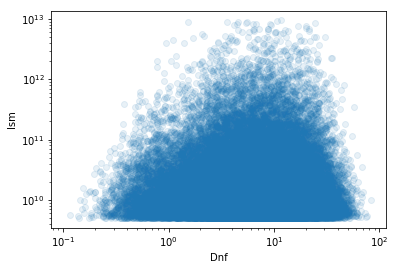

In [13]:
plt.scatter(df_filter.dnf, df_filter.mvir, alpha=.1)
plt.yscale('log')
plt.xscale('log')

#plt.hist2d(np.log10(dnf), np.log10(df_filter.mvir), bins=20)
#plt.colorbar(label='N')

plt.xlabel('Dnf')
plt.ylabel('lsm')

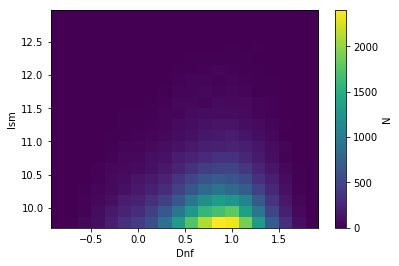

In [14]:
#plt.scatter(dnf, df_filter.mvir, alpha=.1)
plt.hist2d(np.log10(df_filter.dnf), np.log10(df_filter.mvir), bins=20)
plt.colorbar(label='N')
# plt.yscale('log')
# plt.xscale('log')

plt.xlabel('Dnf')
plt.ylabel('lsm')

# Bin selection

##  Bin selection 2017-07-20 19:24:04.184707

In [35]:
logmmin = np.log10(5e9)
logmmax = np.log10(1e13)

mass_bins = 10**(np.linspace(logmmin, logmmax, 7))
nn_bins = np.linspace(0, 100, 5)

nn_bins: [    1.             3.98107171    15.84893192    63.09573445   251.18864315
  1000.        ]


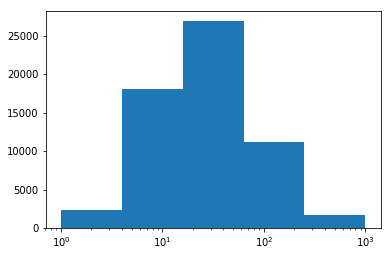

In [36]:
nn_bins = np.logspace(np.log10(1), np.log10(1000), 6)
nn_bins

print('nn_bins:', nn_bins)

plt.hist(df_filter.count_n, bins=nn_bins)
plt.xscale('log')

dnf_bins: [   1.            2.15443469    4.64158883   10.           21.5443469
   46.41588834  100.        ]


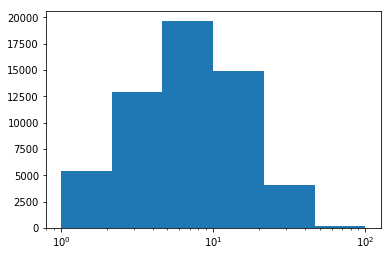

In [38]:
dnf_bins = np.logspace(np.log10(1), np.log10(100), 7)
print('dnf_bins:', dnf_bins)

plt.hist(df_filter.dnf, bins=dnf_bins)
plt.xscale('log')

## Bin selection 2017-07-24 20:16:20.495943

In [61]:
logmmin = np.log10(1e11)
logmmax = np.log10(1e13)

mass_bins = 10**(np.linspace(logmmin, logmmax, 7))
nn_bins = np.linspace(0, 100, 5)

dnf_bins: [   4.            6.83990379   11.69607095   20.           34.19951893
   58.48035476  100.        ]


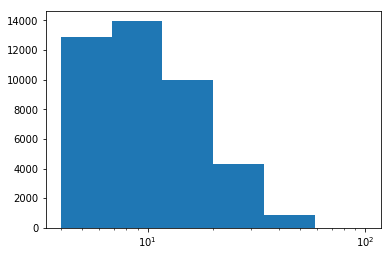

In [62]:
dnf_bins = np.logspace(np.log10(4), np.log10(100), 7)
print('dnf_bins:', dnf_bins)

plt.hist(df_filter.dnf, bins=dnf_bins)
plt.xscale('log')

## Bin assignment

In [63]:
# assign bins to halos
df_filter['mass_bin'] = np.digitize(df_filter.mvir, mass_bins)
df_filter['nn_bin'] = np.digitize(df_filter.count_n, nn_bins)
df_filter['dnf_bin'] = np.digitize(df_filter.dnf, dnf_bins)

In [64]:
gdnf = df_filter.groupby('dnf_bin')
gnn = df_filter.groupby('nn_bin')
gmass = df_filter.groupby('mass_bin')

In [65]:
h = df_filter[df_filter.mass_bin == 6]
g = h.groupby('dnf_bin')

g.count()

hid  mvir  rvir   x   y   z  count_n  dnf  mass_bin  nn_bin
dnf_bin                                                             
0          8     8     8   8   8   8        8    8         8       8
1         15    15    15  15  15  15       15   15        15      15
2         14    14    14  14  14  14       14   14        14      14
3          8     8     8   8   8   8        8    8         8       8
4          7     7     7   7   7   7        7    7         7       7

In [66]:
h = df_filter[df_filter.mass_bin == 6]
g = h.groupby('dnf_bin')

g.count()

hid  mvir  rvir   x   y   z  count_n  dnf  mass_bin  nn_bin
dnf_bin                                                             
0          8     8     8   8   8   8        8    8         8       8
1         15    15    15  15  15  15       15   15        15      15
2         14    14    14  14  14  14       14   14        14      14
3          8     8     8   8   8   8        8    8         8       8
4          7     7     7   7   7   7        7    7         7       7

In [73]:
# randomly select galaxies in bins

n_mass_bins = np.arange(1, 7)
n_dnf_bins = np.arange(1, 7)

selection = {}


for mass_bin in n_mass_bins:
    h = df_filter[df_filter.mass_bin == mass_bin]
    for dnf_bin in n_dnf_bins:
        h2 = h[h.dnf_bin == dnf_bin]
        if len(h2) > 0:
            i = np.random.randint(len(h2))
            selection[(mass_bin, dnf_bin)] = h2.iloc[i].hid
        else:
            selection[(mass_bin, dnf_bin)] = None


In [74]:
df_selected = df_filter.loc[selection.values()]
df_selected = df_selected[df_selected.dnf_bin<100]

# drop the one that matches the bins od 33306
condition = np.logical_and(df_selected.mass_bin == df_filter.loc[33306].mass_bin, df_selected.dnf_bin == df_filter.loc[33306].dnf_bin)
id_to_drop = df_selected[condition].index

df_selected = df_selected.drop(id_to_drop)

# append 33306 to the list
df_selected = df_selected.append(df_filter.loc[33306])
df_selected.sort_values(['mass_bin', 'dnf_bin'], inplace=True)

df_selected

hid          mvir     rvir         x         y         z  \
hid                                                                     
79956    79956.0  1.072000e+11   96.235  15.66532  43.56520   5.52956   
33296    33296.0  1.339000e+11  103.629  15.19173  22.11955  47.41179   
95915    95915.0  1.970000e+11  117.862   8.95348  46.30461  31.73776   
116774  116774.0  1.086000e+11   96.651  24.64649  12.45386   4.11703   
241738  241738.0  1.315000e+11  102.990  47.14500  40.70770  45.55846   
241466  241466.0  3.524000e+11  143.064  30.81929  41.14369  44.99322   
33306    33306.0  2.760000e+11  131.884  10.26344   2.99136  42.59729   
206641  206641.0  2.194000e+11  122.169  44.76641  39.79041  14.08442   
229533  229533.0  2.757000e+11  131.832  31.62716  42.47333  36.76363   
124429  124429.0  3.471000e+11  142.349  46.15647  14.86934  17.27646   
32879    32879.0  6.806000e+11  178.168   1.89003   1.41235  41.26353   
70495    70495.0  6.004000e+11  170.878   0.73130  32.37007  36.46758   
47855    47855.0  6.004000e+11  170.878  12.77474  40.80233   3.24506   
147062  147062.0  9.168000e+11  196.767  32.61589   7.41276  46.25658   
136254  136254.0  6.725000e+11  177.456  42.29634   9.27925  33.19727   
136001  136001.0  1.046000e+12  205.599  28.64865  17.70496  23.64541   
206312  206312.0  1.083000e+12  207.991  42.55681  39.39494   2.92773   
79392    79392.0  1.086000e+12  208.227   4.27934  48.84792   3.93380   
193602  193602.0  1.013000e+12  203.393  30.68392  35.11199  39.08078   
1330      1330.0  1.012000e+12  203.332   0.76788   4.32026   0.06824   
146616  146616.0  3.470000e+12  306.646  44.75562  13.16332  46.09890   
123930  123930.0  3.941000e+12  319.943  23.56157   6.48661  21.87222   
21971    21971.0  2.376000e+12  270.281   3.17315   0.76582  30.14534   
135915  135915.0  2.435000e+12  272.482  45.70159   0.75919  23.11755   
181619  181619.0  2.224000e+12  264.378  20.55832  20.97311  33.76610   
228167  228167.0  4.700000e+12  339.288  41.50275  40.72147  36.09975   
641        641.0  6.806000e+12  383.845  14.11709   7.74389  13.82915   
146457  146457.0  4.977000e+12  345.827  40.70279  12.02742  48.07378   
21720    21720.0  6.339000e+12  374.865  12.77386   8.52803  32.86123   

        count_n        dnf  mass_bin  nn_bin  dnf_bin  
hid                                                    
79956      51.0   6.759611       1.0     3.0      1.0  
33296      35.0   9.191305       1.0     2.0      2.0  
95915      12.0  13.153042       1.0     1.0      3.0  
116774     15.0  28.275509       1.0     1.0      4.0  
241738      9.0  44.698071       1.0     1.0      5.0  
241466    100.0   5.212606       2.0     5.0      1.0  
33306      30.0  11.565937       2.0     2.0      2.0  
206641     19.0  12.365766       2.0     1.0      3.0  
229533     11.0  22.025140       2.0     1.0      4.0  
124429     54.0  57.465814       2.0     3.0      5.0  
32879      34.0   6.711499       3.0     2.0      1.0  
70495      42.0   9.285117       3.0     2.0      2.0  
47855      46.0  12.043975       3.0     2.0      3.0  
147062     40.0  20.475031       3.0     2.0      4.0  
136254     26.0  43.093971       3.0     2.0      5.0  
136001     51.0   6.285262       4.0     3.0      1.0  
206312     38.0   9.624528       4.0     2.0      2.0  
79392      42.0  14.885077       4.0     2.0      3.0  
193602     47.0  21.004236       4.0     2.0      4.0  
1330       23.0  36.327451       4.0     1.0      5.0  
146616     79.0   5.738497       5.0     4.0      1.0  
123930     57.0  10.037510       5.0     3.0      2.0  
21971      64.0  14.052660       5.0     3.0      3.0  
135915     63.0  20.494677       5.0     3.0      4.0  
181619     45.0  35.297392       5.0     2.0      5.0  
228167    114.0   6.828491       6.0     5.0      1.0  
641       158.0   8.831722       6.0     5.0      2.0  
146457    118.0  12.961425       6.0     5.0      3.0  
21720      70.0  21.487323       6.0     3.0      4.0

In [77]:
# save selected subhalos

now = datetime.now()

df_selected.to_hdf("selected.hdf5", key=str(now))

/usr/lib/python3.6/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '2017-07-24 20:16:20.495943'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


# load selected halos

In [22]:
# df_selected = pd.read_hdf("selected.hdf5", key='2017-07-20 19:24:04.184707')
df_selected = pd.read_hdf("selected.hdf5", key='2017-07-24 20:16:20.495943')

In [83]:
x

hid
4898       9.858597
3314      10.388279
4455       9.914132
5677       9.720325
4236       9.947581
7684      10.123525
3095      10.540455
4652       9.777427
2788      10.640879
4953       9.794976
2827      10.405517
4849       9.843544
3585      10.204120
4653       9.891872
3284      10.413803
2686      10.710710
3428      10.310268
2450      10.917611
2885      10.573104
1517      10.120903
1519      10.901349
4454       9.971044
4137      10.037825
4433      10.017868
5010       9.843544
1523      10.201943
1524      11.632255
3938      10.041393
3297      10.402777
1330      12.005181
            ...    
243705     9.900913
242928    10.188366
242998    10.118265
243866     9.789228
242878     9.800648
242002    10.792672
241454    11.552547
244274     9.752970
243387     9.935306
244257     9.752970
243231    10.050766
242567    10.351989
242448    10.446848
243232    10.044540
244019     9.817235
243105     9.887280
242012    10.664642
242013     9.858597
242328     9.733

/usr/lib/python3.6/site-packages/matplotlib/colorbar.py:871: RuntimeWarning: invalid value encountered in true_divide
  z = np.take(y, i0) + (xn - np.take(b, i0)) * dy / db


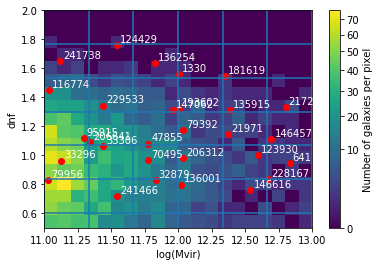

In [86]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

x = np.log10(df_filter.mvir)
y = np.log10(df_filter.dnf)


density = ax.scatter_density(x, y, norm=PowerNorm(0.5), dpi=6)

ax.scatter(np.log10(df_selected.mvir), np.log10(df_selected.dnf), color='r')

# Annotate with hid labels
annotate = True
for i in range(len(df_selected)):
    s = int(df_selected.iloc[i].hid)
    xy = (df_selected.iloc[i].mvir, df_selected.iloc[i].dnf)
    if annotate:
        plt.annotate(s, np.log10(xy), xytext=(3, 3), textcoords='offset points', color='w')


fig.colorbar(density, label='Number of galaxies per pixel')

for mb in np.log10(mass_bins):
    plt.axvline(mb)
    
for dnfb in np.log10(dnf_bins):
    plt.axhline(dnfb)

plt.xlim(11, 13)
plt.ylim(0.5, 2)

    
plt.xlabel('log(Mvir)')
plt.ylabel('dnf')

In [22]:
from gadget import pygadget

In [23]:
snap = pygadget.Simulation('/home/lbignone/simulations/out512/snapshot_014', multiple_files=True)

In [46]:
%%time

radius = 1000

with ProgressBar(len(df_selected), ipython_widget=True) as pbar:
    for hid in df_selected.index:

        center = halos[['x', 'y', 'z']].loc[hid]
        center = center.values * cat_ulength.to(cat.snapshot.simulation.gadgetsimulation.unit_length)

        ids = snap.select_ids_in_radius(center, radius, 'halo')

        pos = snap.read_block_by_ids('pos', 'halo', ids)
        
        pos.to_hdf('selected.hdf5', key='s'+str(hid))
        
        del(pos)
        
        pbar.update()

MemoryError: 

In [97]:
a = nn.loc[hid]
a.ndim

nn.ndim

2

In [87]:
def plot_subhalos(df_subs, center, ax, axis=['x', 'y'], edgecolor='w'):
    def execute(hid, data):
        spos = data[['x', 'y', 'z']] * cat_ulength.to(cat.snapshot.simulation.gadgetsimulation.unit_length) - center
        spos = spos[axis]
        rvir = data['rvir']
        
        circle = plt.Circle(spos, radius=rvir, fill=False, edgecolor=edgecolor)
        ax.add_artist(circle)        
    
    if df_subs.ndim > 1:
        for hid, data in df_subs.iterrows():
            execute(hid, data)
    else:
        hid = df_subs.name
        execute(hid, df_subs)    

In [88]:
def analize_region(hid, radius=1000 * cat_rlength):
    
    center = halos[['x', 'y', 'z']].loc[hid]
    center = center.values * cat_ulength.to(cat.snapshot.simulation.gadgetsimulation.unit_length)
    
    ids = snap.select_ids_in_radius(center, radius.value, 'halo')
    pos = snap.read_block_by_ids('pos', 'halo', ids)
    
    posc = pos - center
     
    ind = halos_tree.query_ball_point(halos.loc[hid][['x', 'y', 'z']], radius.to(cat_ulength).value)

    nn = halos.iloc[ind]
    
    projections = [['x', 'y'], ['x', 'z'], ['y', 'z']] 

    fig = plt.figure(figsize=(21, 7))
    
    for i, proj in enumerate(projections):
    
        ax = fig.add_subplot(1, 3, i+1, projection='scatter_density')

        density = ax.scatter_density(posc[proj[0]], posc[proj[1]], norm=PowerNorm(0.2))

        plot_subhalos(nn, center, ax, axis=proj)

        ax.set_xlabel(proj[0])
        ax.set_ylabel(proj[1])

    plt.tight_layout()
    
    return posc

In [89]:
def rockstar_length_to_gadget(value):
    result = value * cat_ulength.to(cat.snapshot.simulation.gadgetsimulation.unit_length)
    return result

def gadget_length_to_rockstar(value):
    result = value * cat.snapshot.simulation.gadgetsimulation.unit_length.to(cat_ulength)
    return result

In [90]:
def get_center(df):
    return df[['x', 'y', 'z']]

df_selected.loc[hid].rvir

In [94]:
box_l = 50000

def recenter(pos):
    pos = pos.where(pos>-(box_l/2.0), other=pos+box_l)
    pos = pos.where(pos<(box_l/2.0), other=pos-box_l)
    
    return pos

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


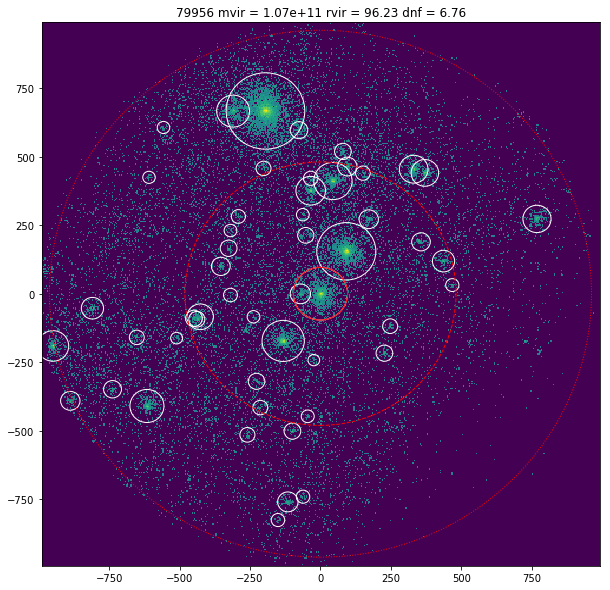

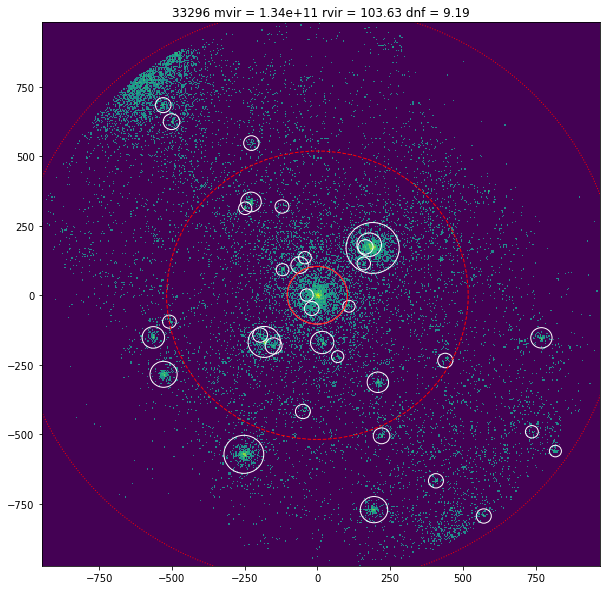

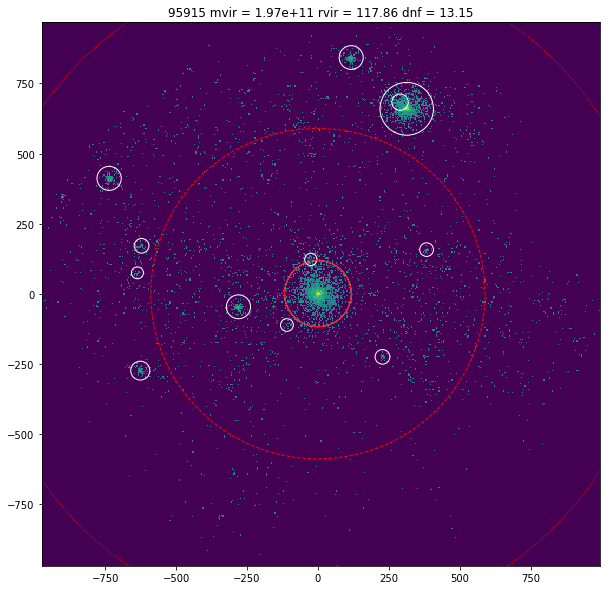

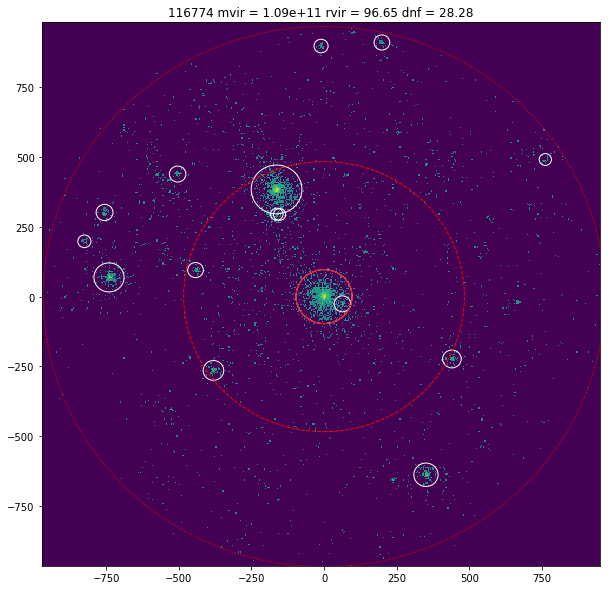

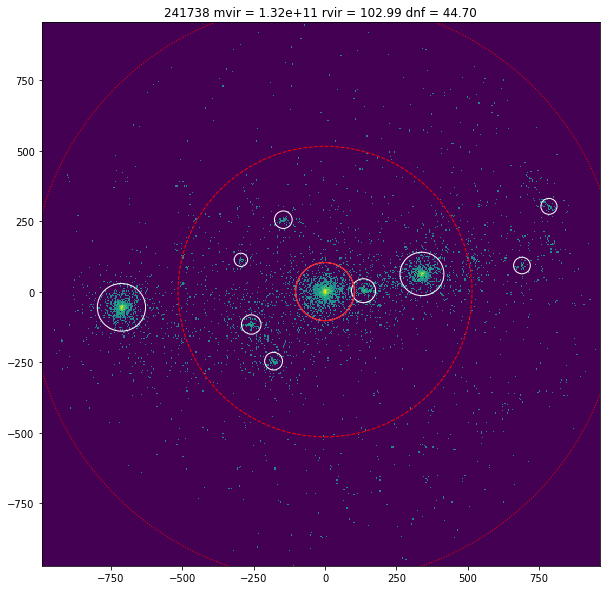

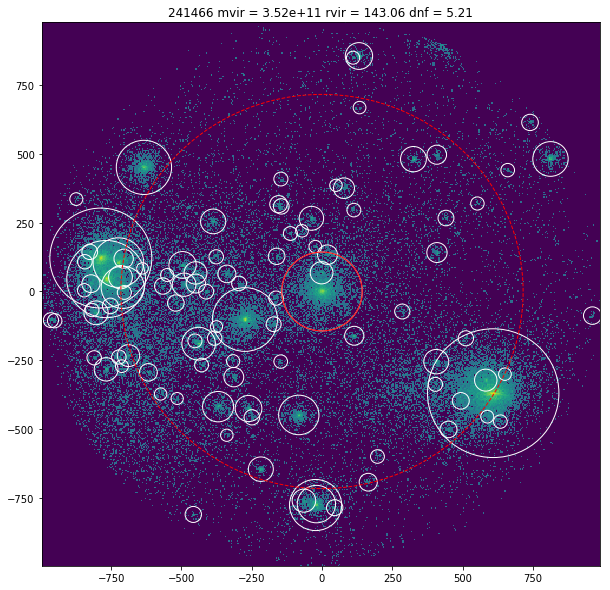

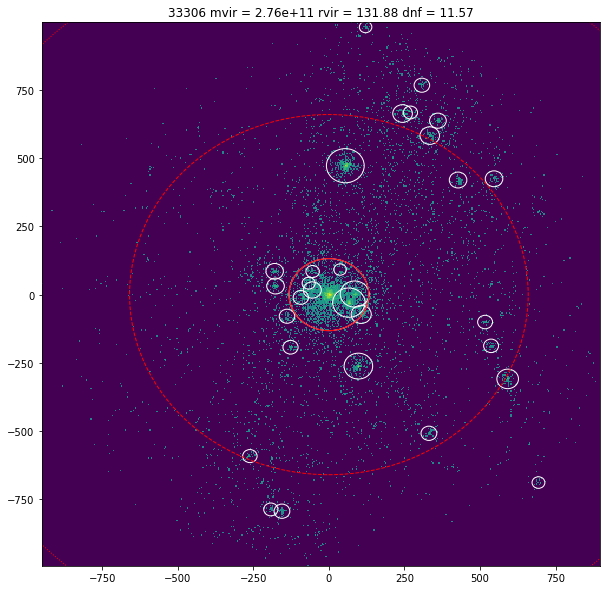

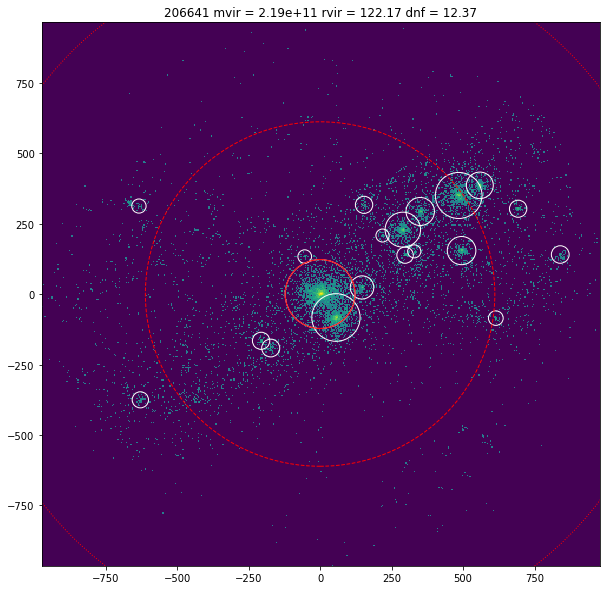

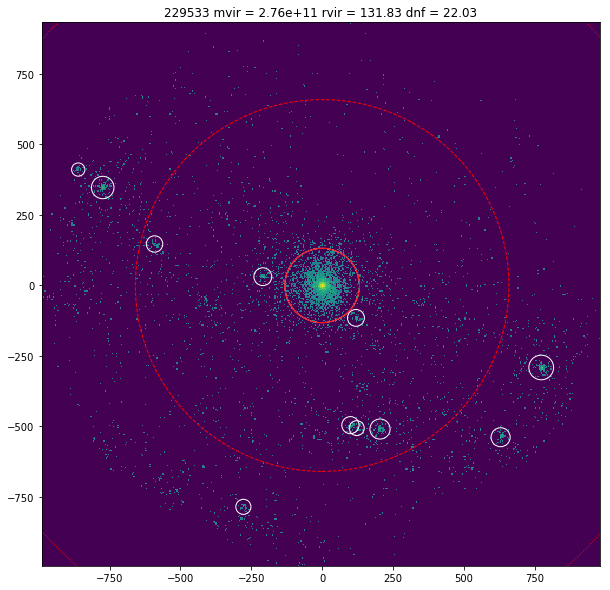

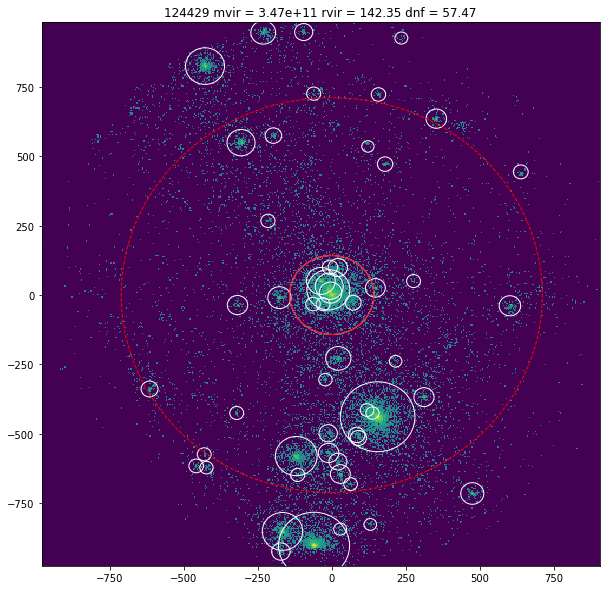

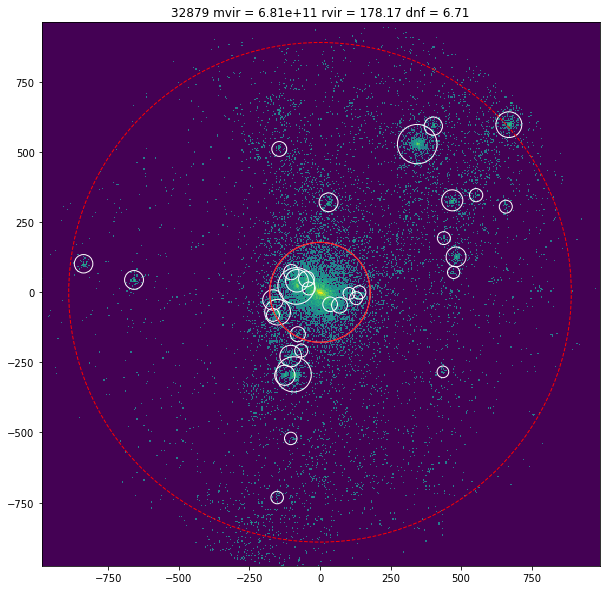

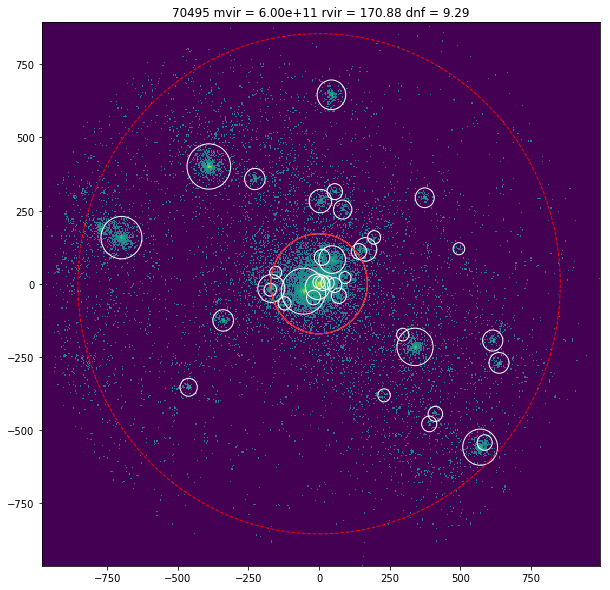

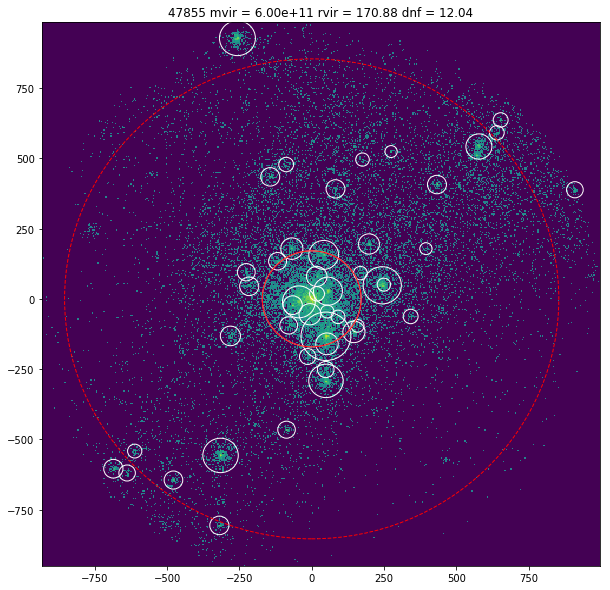

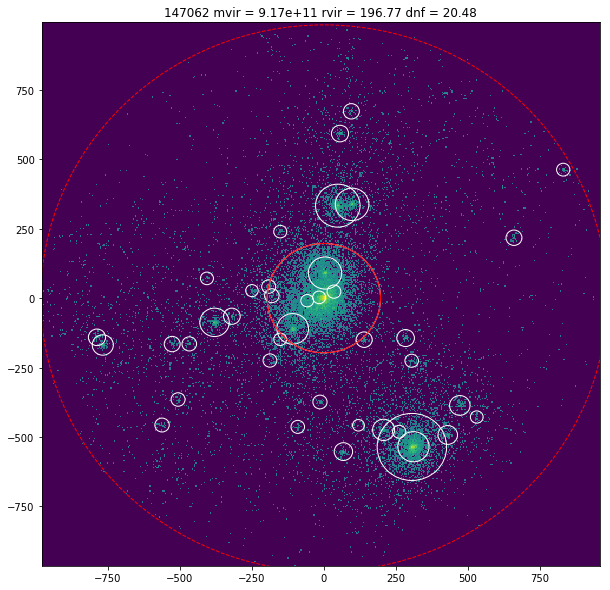

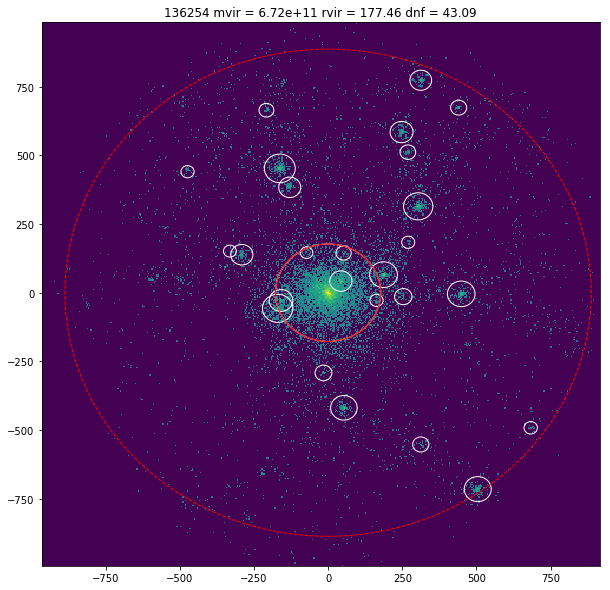

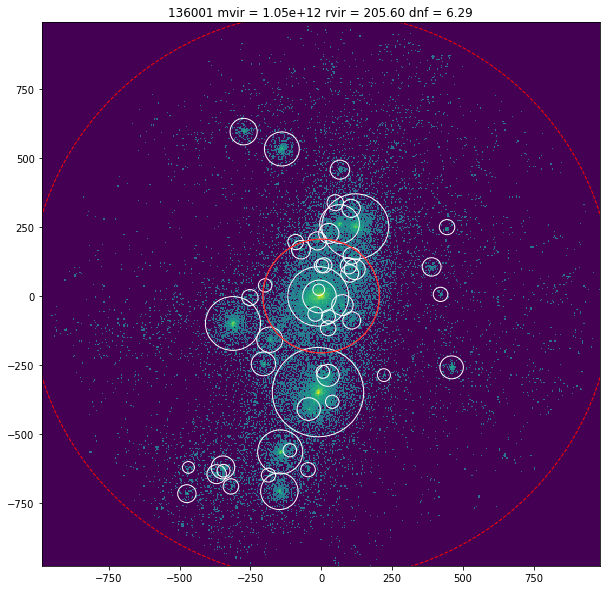

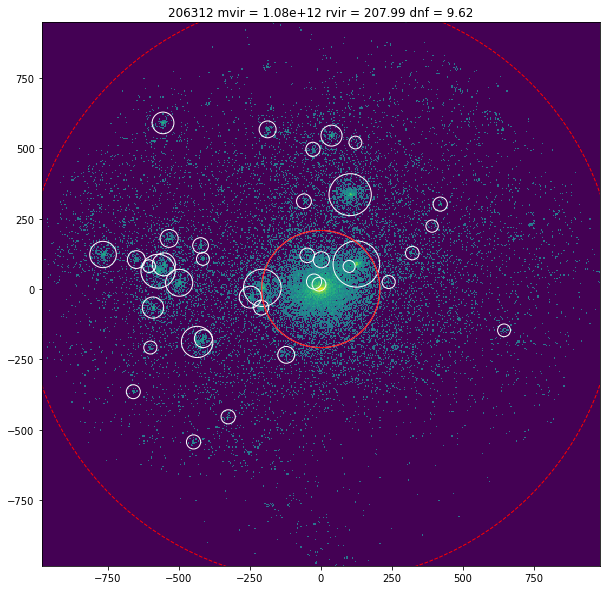

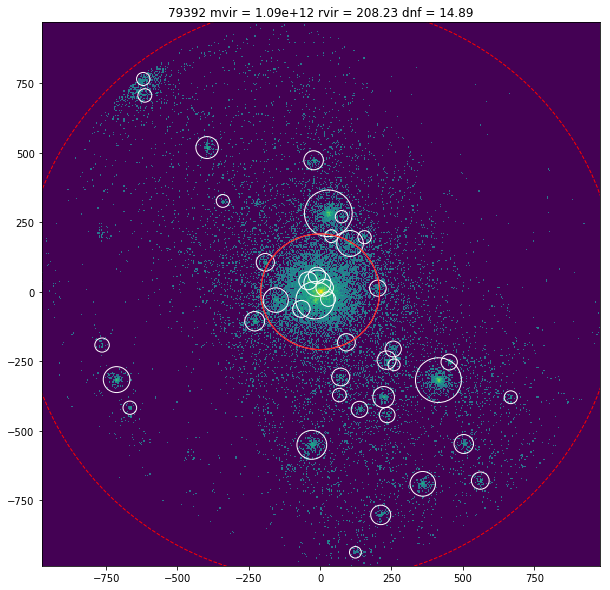

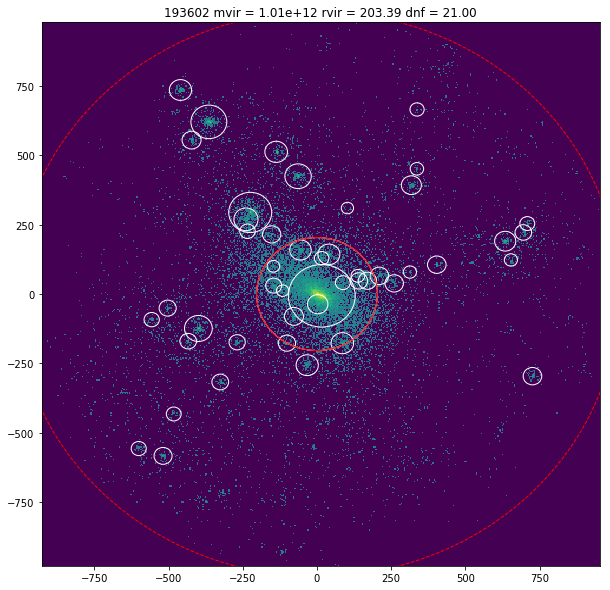

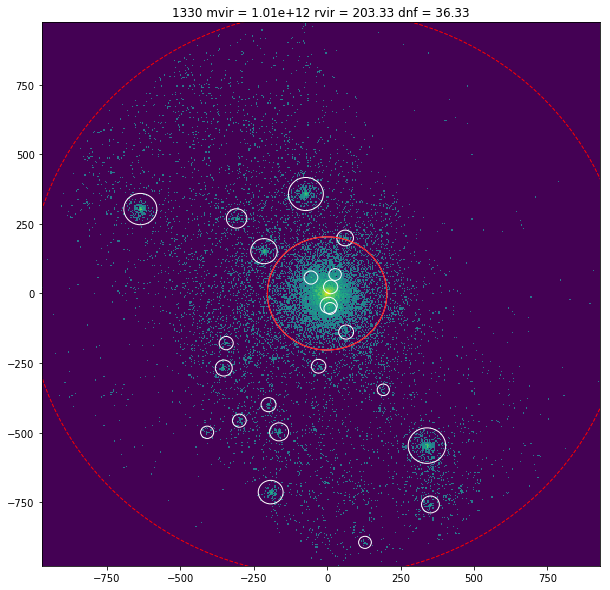

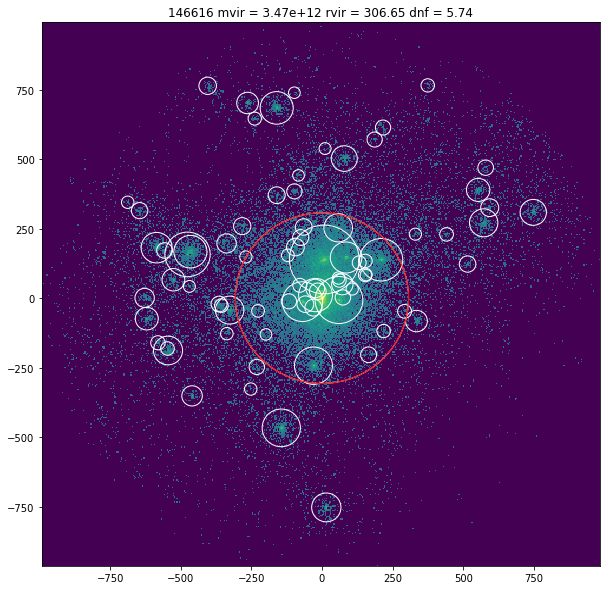

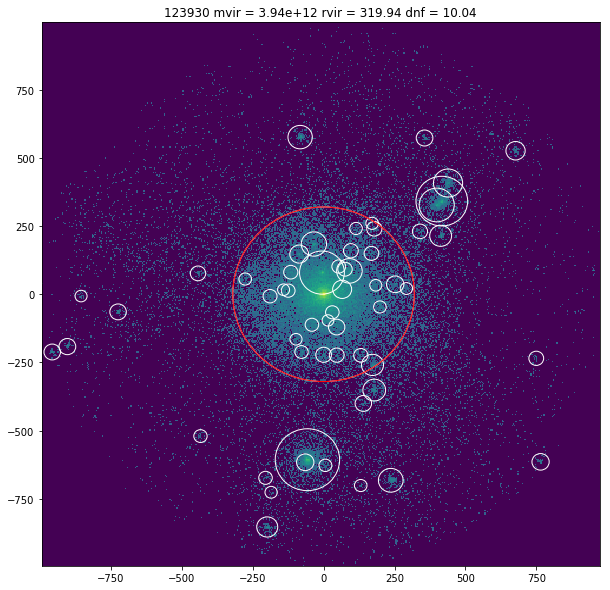

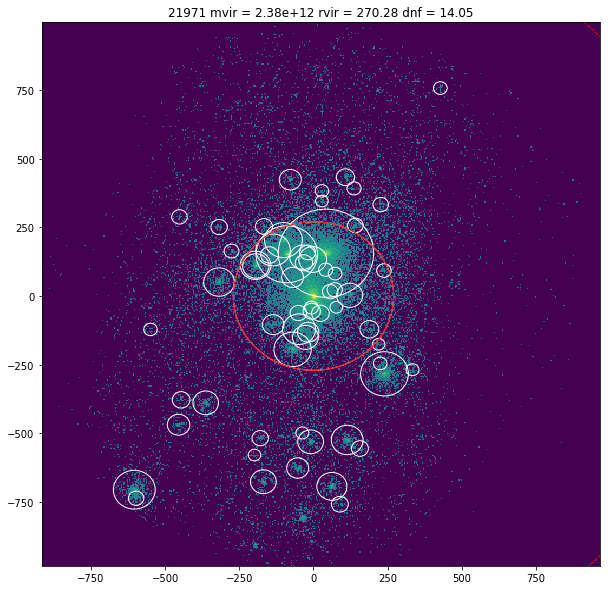

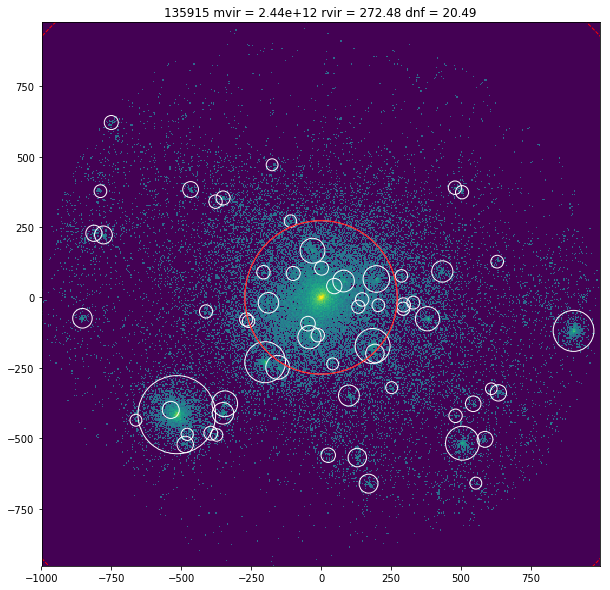

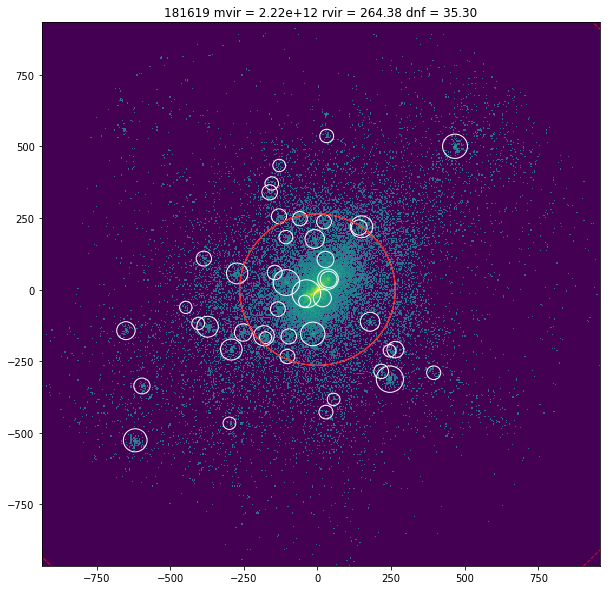

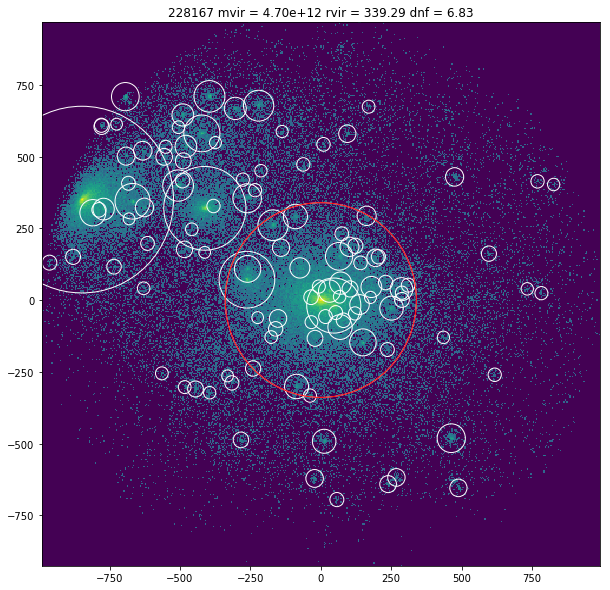

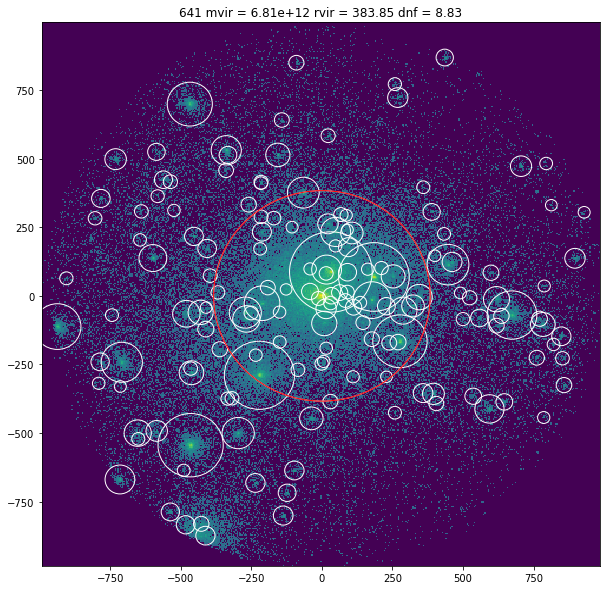

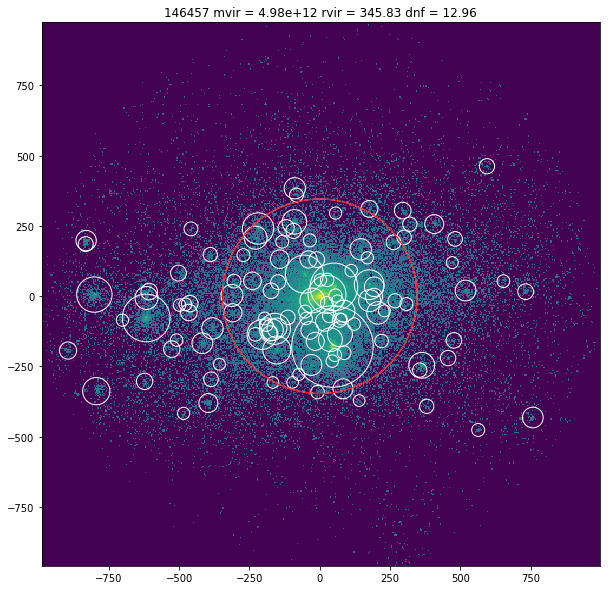

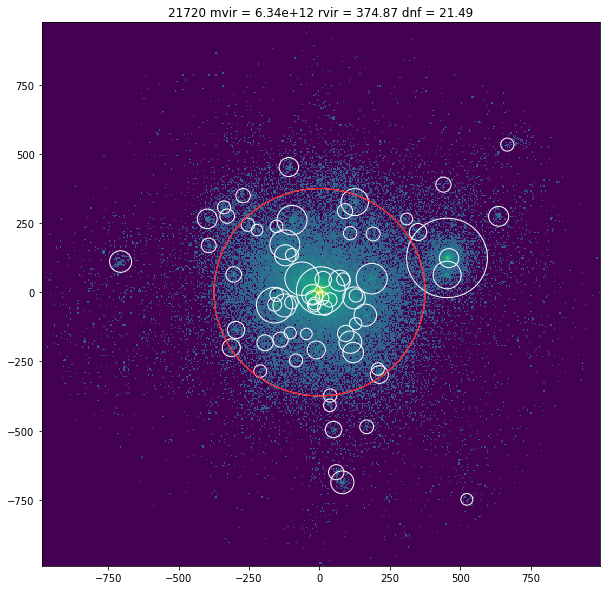

In [95]:
sids = df_selected.index

with ProgressBar(len(sids), ipython_widget=True) as pbar:

    for hid in sids:

        pos = pd.read_hdf('selected.hdf5', key='s' + str(hid))

        # find neighbours

        center_R = get_center(df_selected.loc[hid])
        center_G = rockstar_length_to_gadget(center_R.values)
        
        pos -= center_G
        
        pos = recenter(pos)

        radius = df_selected.loc[hid].rvir
        radius = 1000
        radius = gadget_length_to_rockstar(radius)

        ind = halos_tree.query_ball_point(center_R, radius)

        nn = halos.iloc[ind]

        # plot region

        fig = plt.figure(figsize=(10, 10))

        ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

        density = ax.scatter_density(pos.x, pos.y, norm=PowerNorm(0.2))

        plot_subhalos(nn, center_G, ax, edgecolor='w')

        # highlight central halo

        plot_subhalos(nn.loc[hid], center_G, ax, edgecolor='r')
        for factor, ls in zip([5, 10], ['--', ':']):

            radius = factor * nn.loc[hid].rvir

            circle = plt.Circle((0, 0), radius, fill=False, edgecolor='r', linestyle=ls)

            ax.add_artist(circle)
        
        title = str(hid) + ' mvir = {mvir:.2e}' + ' rvir = {rvir:.2f}' + ' dnf = {dnf:.2f}'
        
        df = df_selected.loc[hid]
        title = title.format(mvir=df.mvir, rvir=df.rvir, dnf=df.dnf)
        
        plt.title(title)
               
        plt.savefig('selected_figures/s' + str(hid) + '.jpg')
        # plt.close(fig)
        
        pbar.update()

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


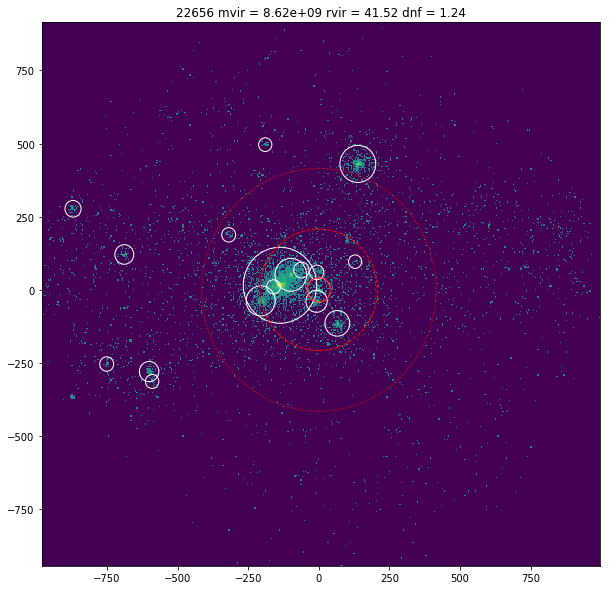

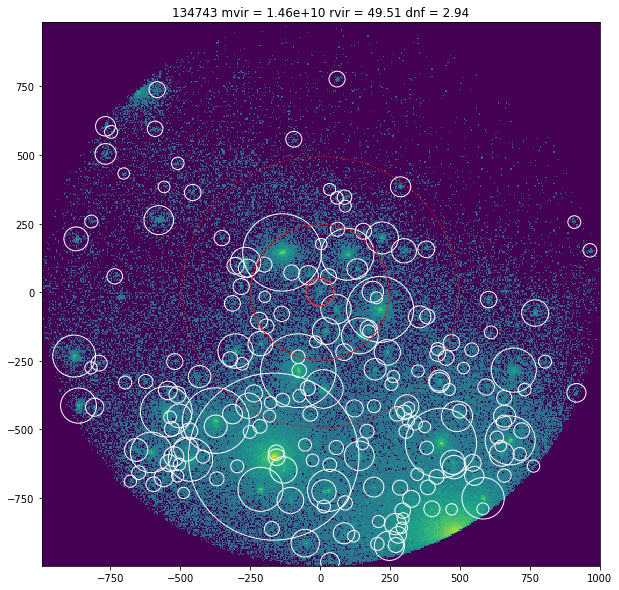

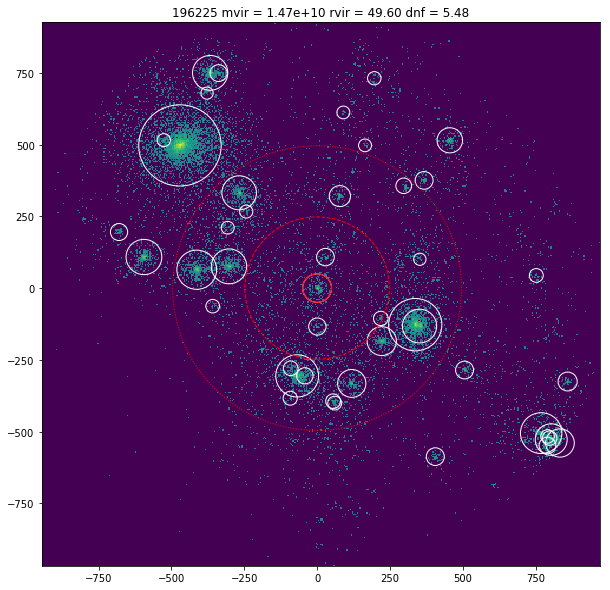

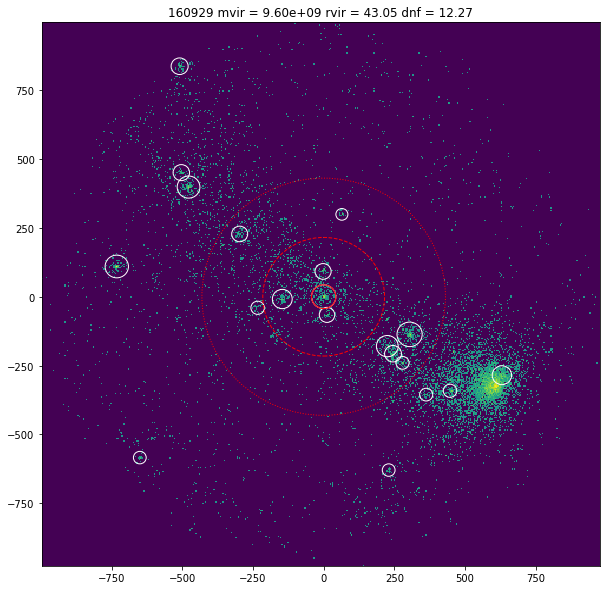

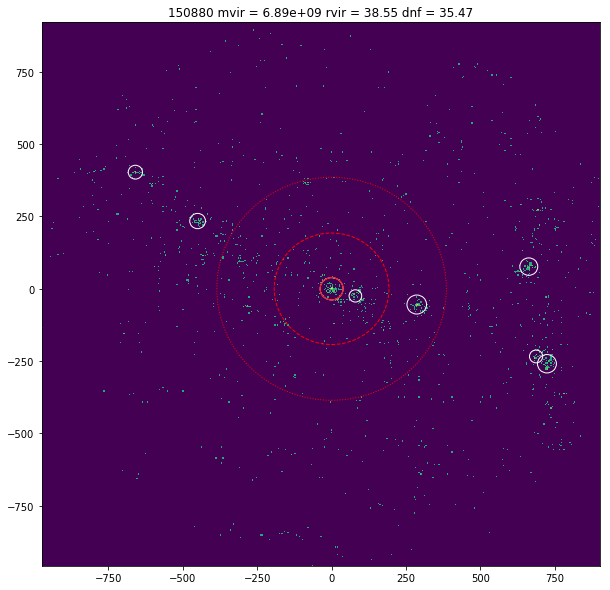

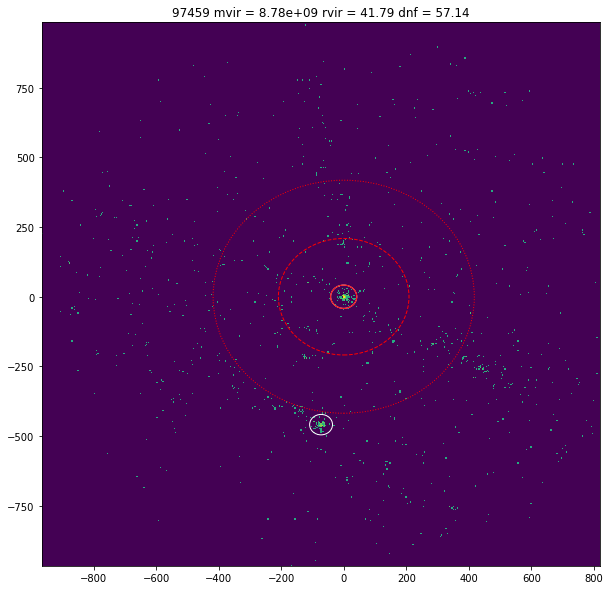

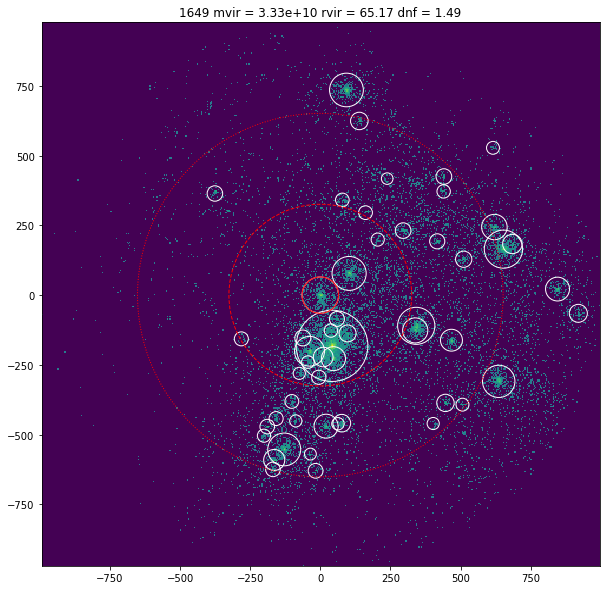

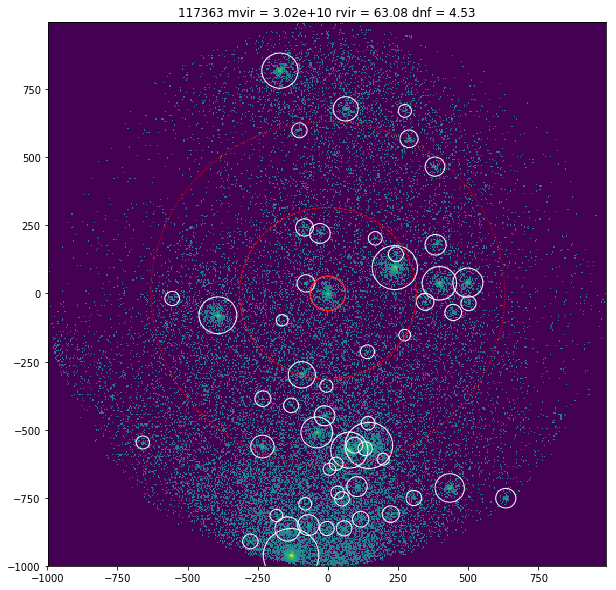

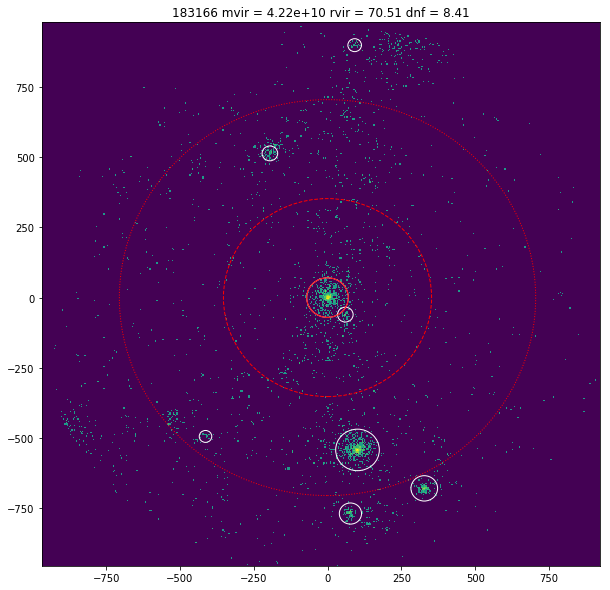

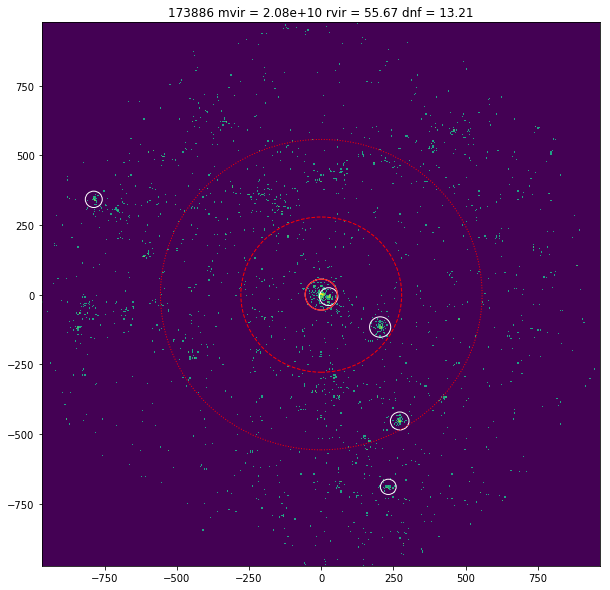

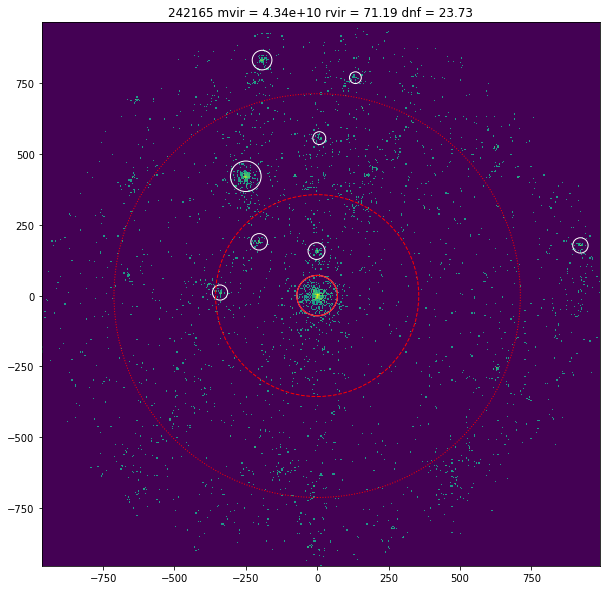

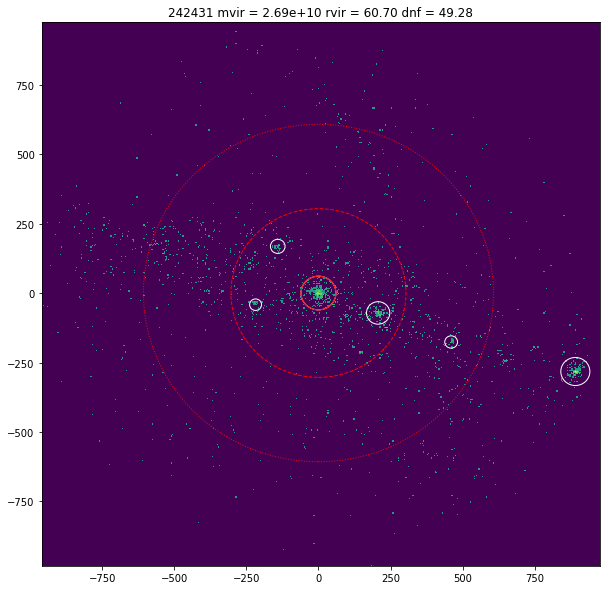

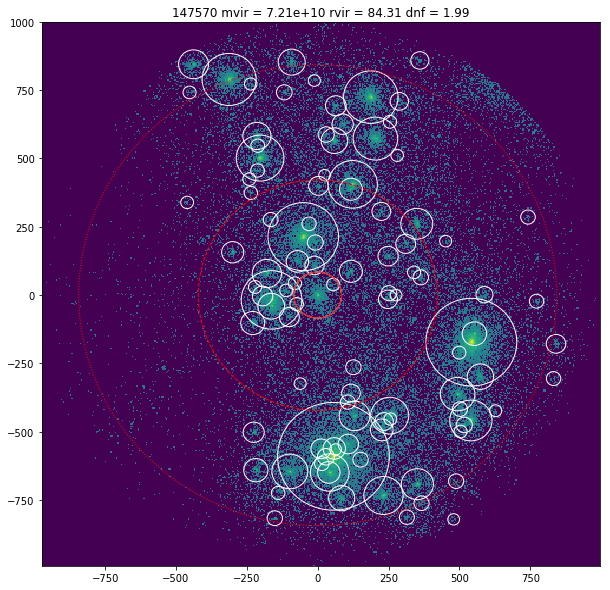

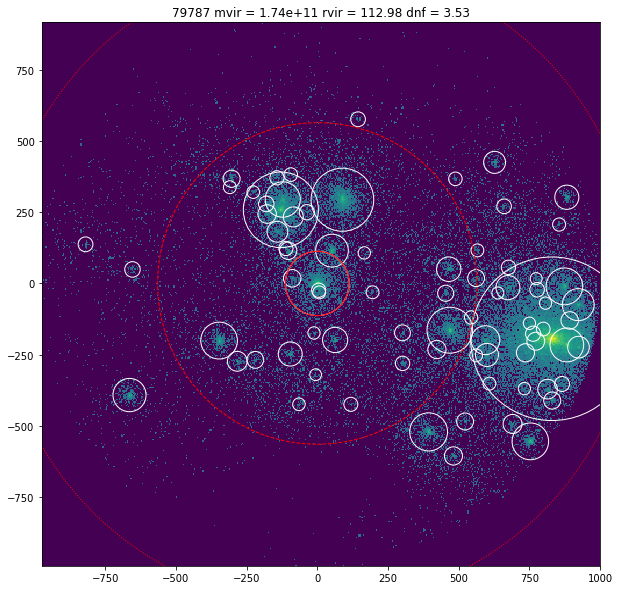

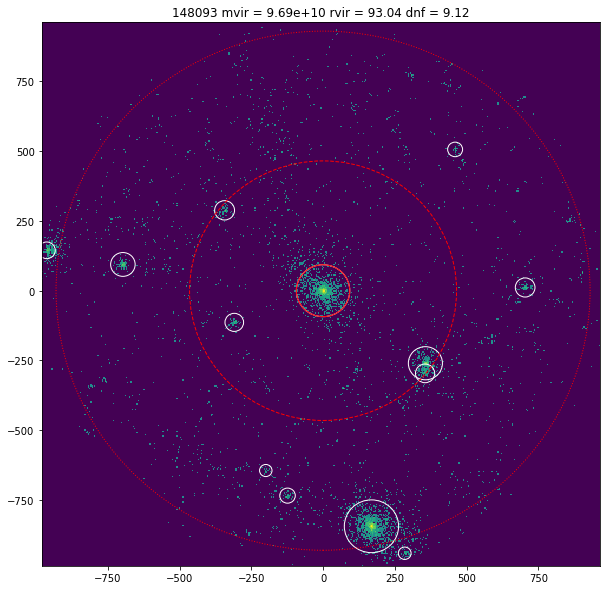

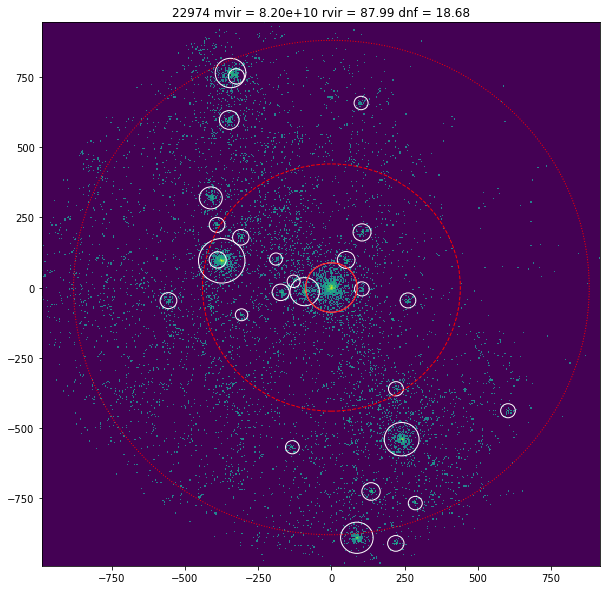

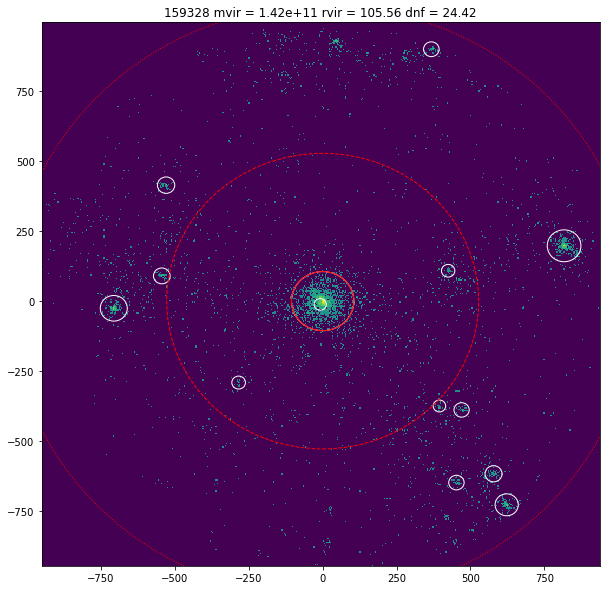

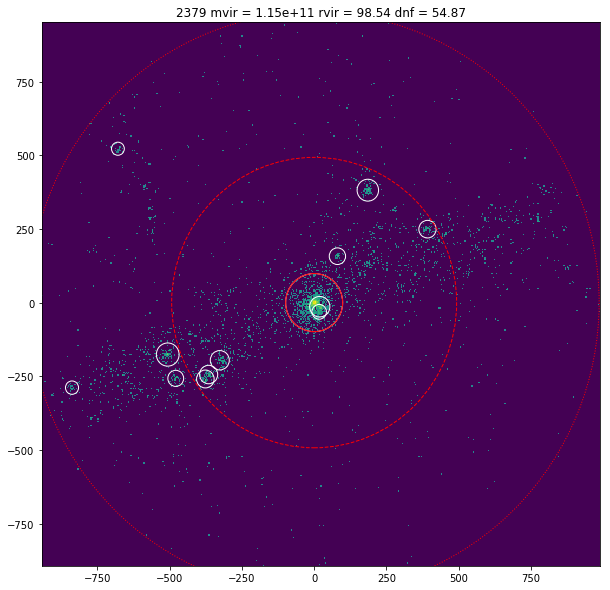

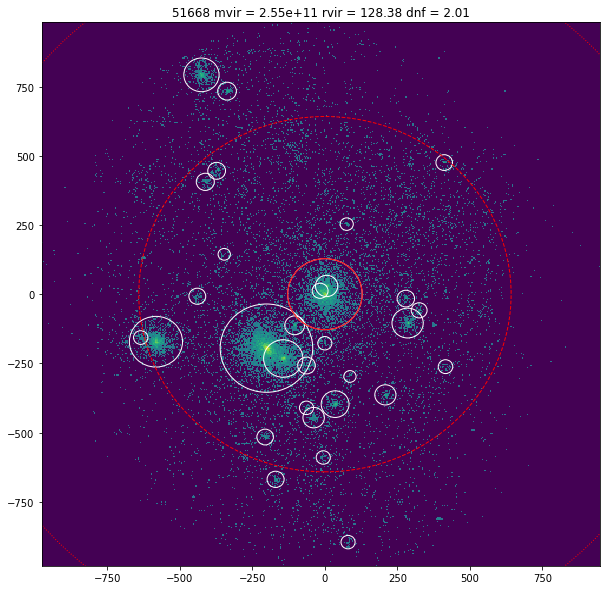

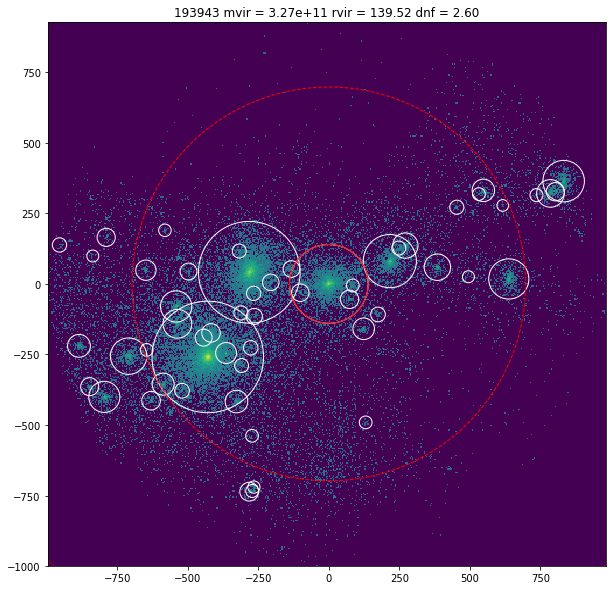

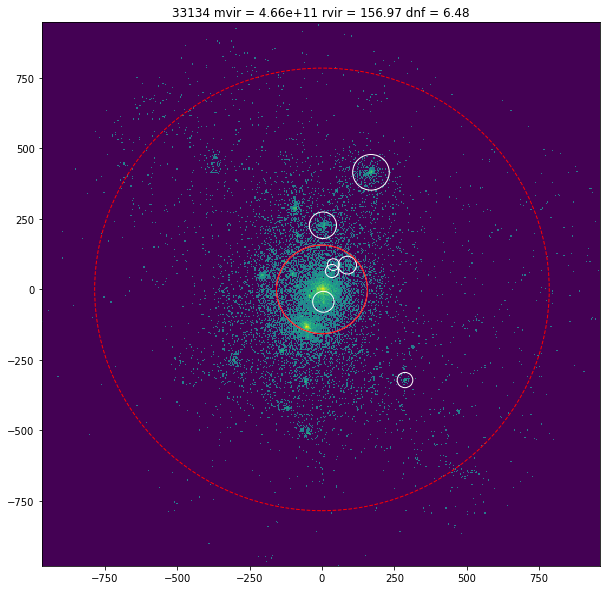

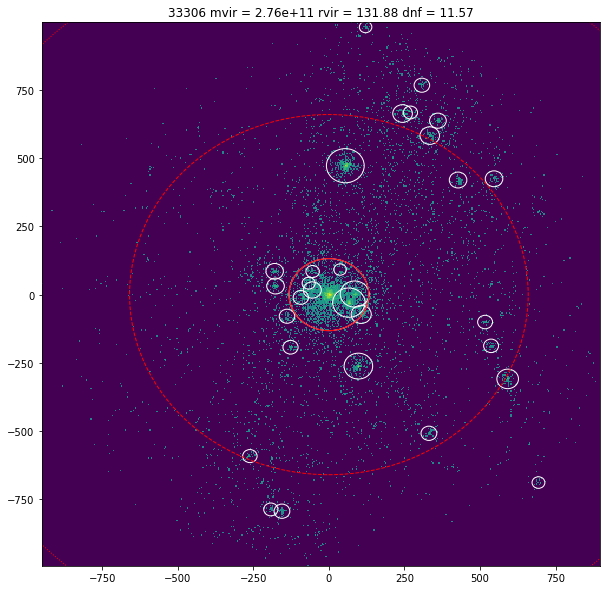

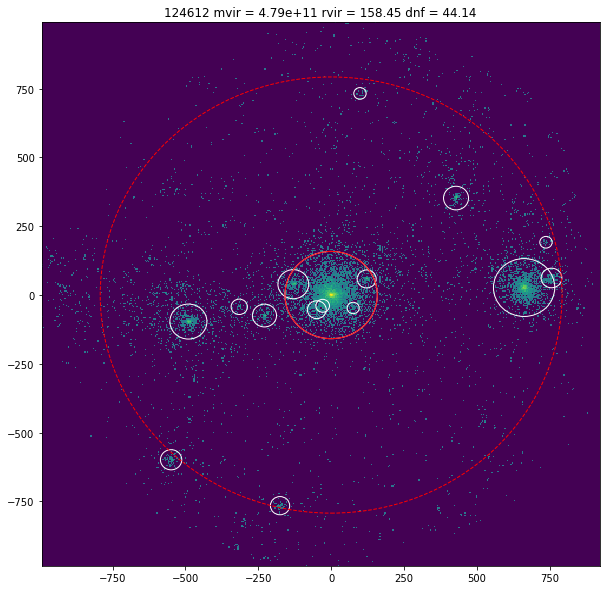

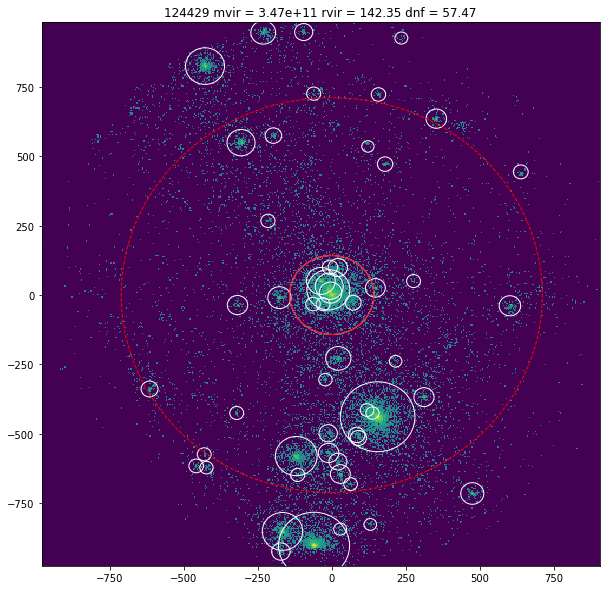

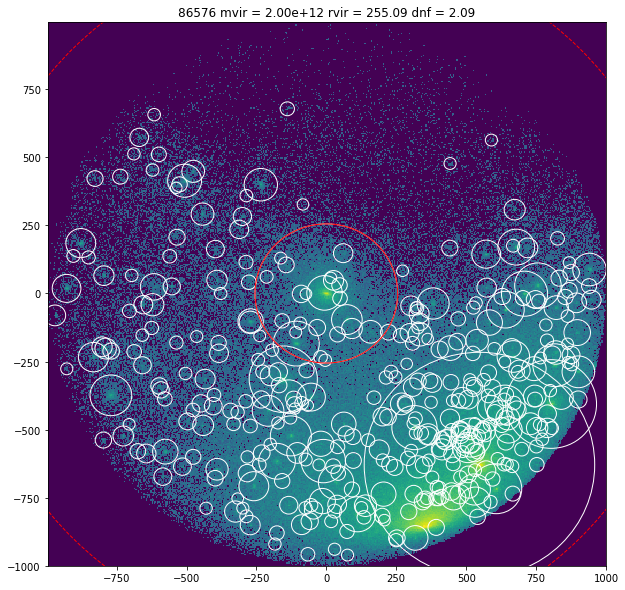

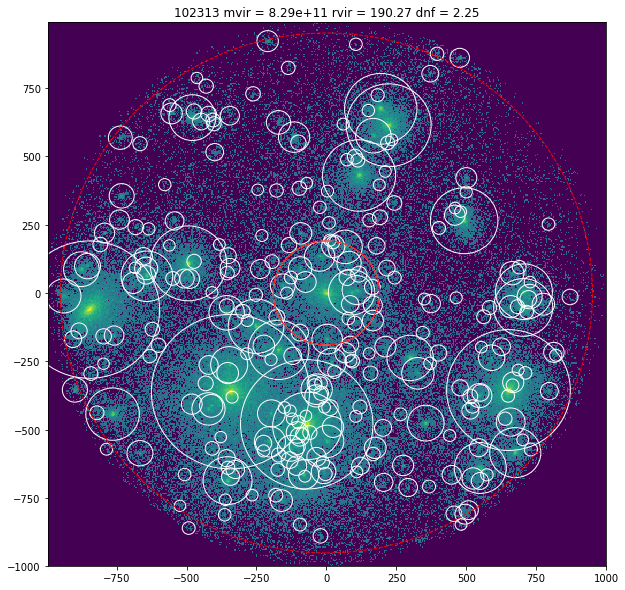

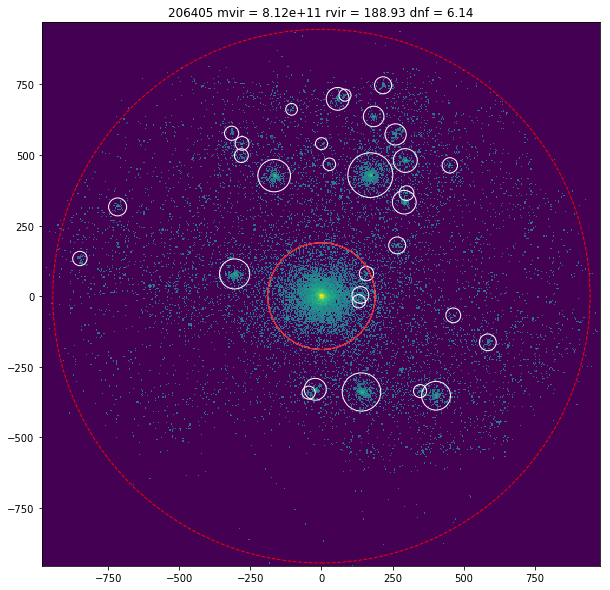

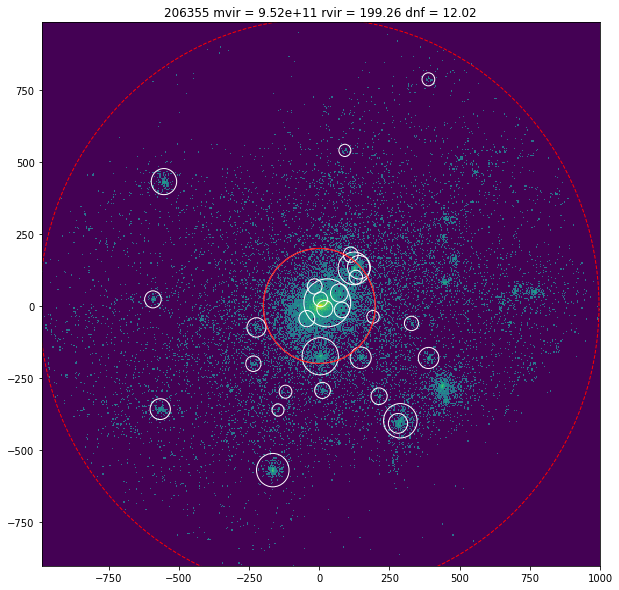

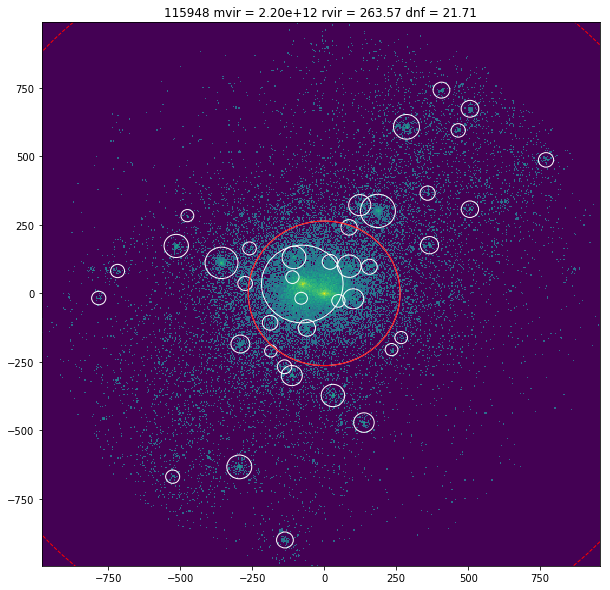

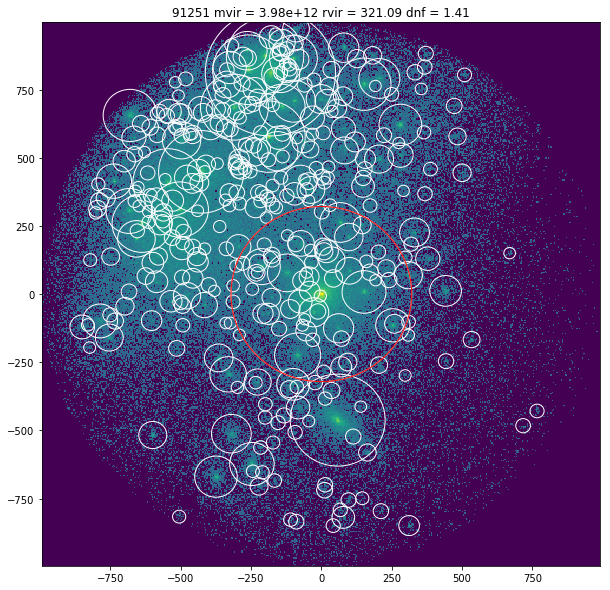

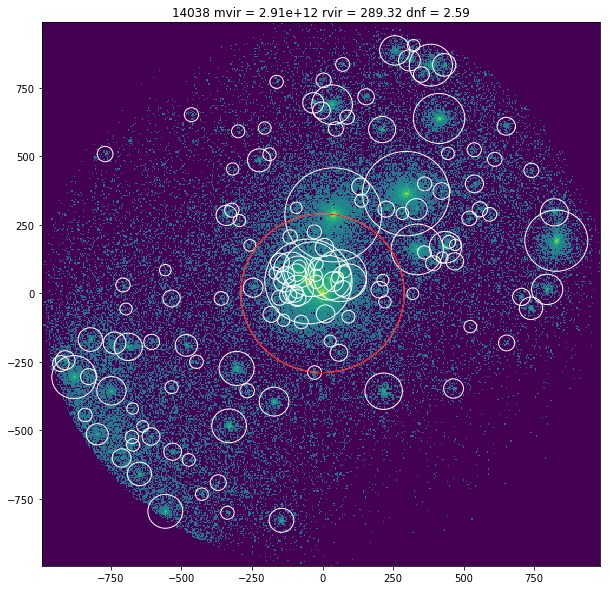

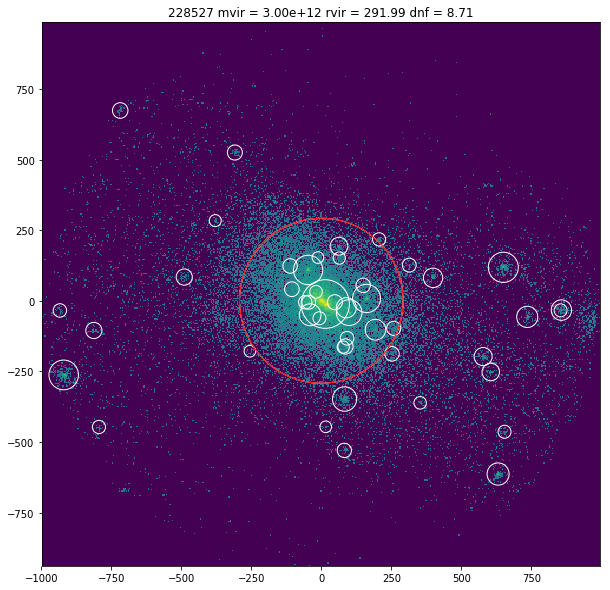

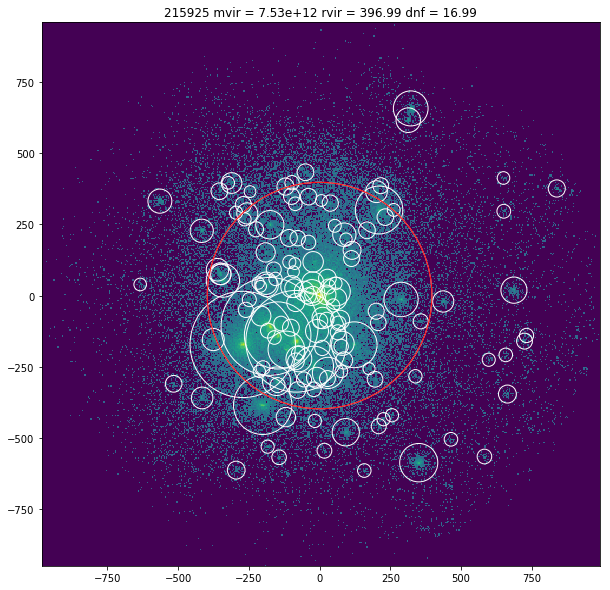

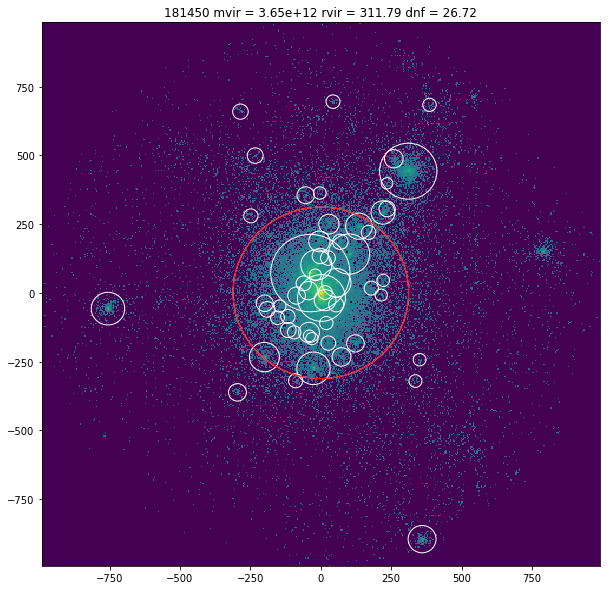

In [201]:
sids = df_selected.index

with ProgressBar(len(sids), ipython_widget=True) as pbar:

    for hid in sids:

        pos = pd.read_hdf('selected.hdf5', key='s' + str(hid))

        # find neighbours

        center_R = get_center(df_selected.loc[hid])
        center_G = rockstar_length_to_gadget(center_R.values)
        
        pos -= center_G
        
        pos = recenter(pos)

        radius = df_selected.loc[hid].rvir
        radius = 1000
        radius = gadget_length_to_rockstar(radius)

        ind = halos_tree.query_ball_point(center_R, radius)

        nn = halos.iloc[ind]

        # plot region

        fig = plt.figure(figsize=(10, 10))

        ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

        density = ax.scatter_density(pos.x, pos.y, norm=PowerNorm(0.2))

        plot_subhalos(nn, center_G, ax, edgecolor='w')

        # highlight central halo

        plot_subhalos(nn.loc[hid], center_G, ax, edgecolor='r')
        for factor, ls in zip([5, 10], ['--', ':']):

            radius = factor * nn.loc[hid].rvir

            circle = plt.Circle((0, 0), radius, fill=False, edgecolor='r', linestyle=ls)

            ax.add_artist(circle)
        
        title = str(hid) + ' mvir = {mvir:.2e}' + ' rvir = {rvir:.2f}' + ' dnf = {dnf:.2f}'
        
        df = df_selected.loc[hid]
        title = title.format(mvir=df.mvir, rvir=df.rvir, dnf=df.dnf)
        
        plt.title(title)
               
        plt.savefig('selected_figures/s' + str(hid) + '.jpg')
        # plt.close(fig)
        
        pbar.update()